## Section a

In [1]:
from urllib.request import urlopen
wiki = "https://en.wikipedia.org/wiki/Gal_Gadot"
page = urlopen(wiki)
from bs4 import BeautifulSoup
soup = BeautifulSoup(page, 'lxml')

right_table=soup.find('table', class_='wikitable sortable')

In [2]:
import numpy as np
import pandas as pd

"""
The following 3 functions were taken from stackoverflow. These are used to parse wiki
tables properly and to insert them into a pandas' dataframe
"""

def pre_process_table(table):
    """
    INPUT:
        1. table - a bs4 element that contains the desired table: ie <table> ... </table>
    OUTPUT:
        a tuple of: 
            1. rows - a list of table rows ie: list of <tr>...</tr> elements
            2. num_rows - number of rows in the table
            3. num_cols - number of columns in the table
    Options:
        include_td_head_count - whether to use only th or th and td to count number of columns (default: False)
    """
    rows = [x for x in table.find_all('tr')]

    num_rows = len(rows)

    # get an initial column count. Most often, this will be accurate
    num_cols = max([len(x.find_all(['th','td'])) for x in rows])

    # sometimes, the tables also contain multi-colspan headers. This accounts for that:
    header_rows_set = [x.find_all(['th', 'td']) for x in rows if len(x.find_all(['th', 'td']))>num_cols/2]

    num_cols_set = []

    for header_rows in header_rows_set:
        num_cols = 0
        for cell in header_rows:
            row_span, col_span = get_spans(cell)
            num_cols+=len([cell.getText()]*col_span)

        num_cols_set.append(num_cols)

    num_cols = max(num_cols_set)

    return (rows, num_rows, num_cols)


def get_spans(cell):
        """
        INPUT:
            1. cell - a <td>...</td> or <th>...</th> element that contains a table cell entry
        OUTPUT:
            1. a tuple with the cell's row and col spans
        """
        if cell.has_attr('rowspan'):
            rep_row = int(cell.attrs['rowspan'])
        else: # ~cell.has_attr('rowspan'):
            rep_row = 1
        if cell.has_attr('colspan'):
            rep_col = int(cell.attrs['colspan'])
        else: # ~cell.has_attr('colspan'):
            rep_col = 1 

        return (rep_row, rep_col)

def process_rows(rows, num_rows, num_cols):
    """
    INPUT:
        1. rows - a list of table rows ie <tr>...</tr> elements
    OUTPUT:
        1. data - a Pandas dataframe with the html data in it
    """
    data = pd.DataFrame(np.ones((num_rows, num_cols))*np.nan)
    for i, row in enumerate(rows):
        try:
            col_stat = data.iloc[i,:][data.iloc[i,:].isnull()].index[0]
        except IndexError:
            print(i, row)

        for j, cell in enumerate(row.find_all(['td', 'th'])):
            rep_row, rep_col = get_spans(cell)

            #print("cols {0} to {1} with rep_col={2}".format(col_stat, col_stat+rep_col, rep_col))
            #print("\trows {0} to {1} with rep_row={2}".format(i, i+rep_row, rep_row))

            #find first non-na col and fill that one
            while any(data.iloc[i,col_stat:col_stat+rep_col].notnull()):
                col_stat+=1

            data.iloc[i:i+rep_row,col_stat:col_stat+rep_col] = cell.getText()
            if col_stat<data.shape[1]-1:
                col_stat+=rep_col

    return data

rows, num_rows, num_cols = pre_process_table(right_table)
df = process_rows(rows, num_rows, num_cols)

df.columns = ['Year', 'Title', 'Role', 'Director', 'Notes']

df = df.drop(['Notes'], axis=1)
df = df.drop(0)

df = df.applymap(str.rstrip)

df

,Year,Title,Role,Director
1,2009,Fast & Furious,Gisele Yashar,Justin Lin
2,2010,Date Night,Natanya,Shawn Levy
3,2010,Knight and Day,Naomi,James Mangold
4,2011,Fast Five,Gisele Yashar,Justin Lin
5,2013,Fast & Furious 6,Gisele Yashar,Justin Lin
6,2014,Kicking Out Shoshana,Mirit Ben Harush,Shay Kanot
7,2015,Furious 7,Gisele Yashar,James Wan
8,2016,Triple 9,Elena Vlaslov,John Hillcoat
9,2016,Batman v Superman: Dawn of Justice,Diana Prince / Wonder Woman,Zack Snyder
10,2016,Criminal,Jill Pope,Ariel Vromen


## Section b

In [3]:
# collecting all relevant links
links = []
for row in right_table.findAll("tr"):
    if row.find('a') is not None:
        links.append("https://en.wikipedia.org" + str(row.find('a').get('href')))


In [4]:
#iterate each link in order to open them and exctract relevant information.
joint_movies = {}
col1_names =[]
names = {}
i = 1
for link in links:
    all_li = []
    cont = True
    page = urlopen(link)
    soup = BeautifulSoup(page, 'lxml')
    cast_span = soup.find("span", id="Cast")
    if cast_span is None:
        continue # in case the movie doesn't have a wiki page, we ignore it

    ul = cast_span.parent.findNext('ul')
    second_format = False
    # taking care of specific format which 'ul' include only one 'li' which represent an actor.
    if len(ul) == 1:
        second_format = True
        while cont:
            try :
                cont = ul.find('li').find('a') is not None and ul.find('li').find('a')['title'].replace(" ", "").isalpha() and ul.find('li').find('a').text != 'Official website'
            except:
                break
            if ul.find('li').find('a') is not None:
                all_li.append(ul.find('li'))
            
            ul = ul.findNext('ul')

    if ul is None:
        print('ul is none '+ str(link))
    if not second_format:
        all_li = ul.find_all('li')
    if all_li is None:
        print('all_li is none\n' + link)
    i = i +1
    for li in all_li:
        tmp_a = li.find('a')
        if tmp_a is not None:            
            names[tmp_a.text] = "https://en.wikipedia.org" + str(tmp_a['href'])
            if tmp_a.text in joint_movies:
                joint_movies[tmp_a.text] += 1
            else:
                joint_movies[tmp_a.text] = 1

del joint_movies['Gal Gadot'] # if we want to ignore gal

In [5]:
import re

class Actor:
    name = None
    year_of_birth = None
    country = None
    awards = None

In [6]:
def updateBirthYear(actor, soup, wiki_url):
    #extracting bday from html
    bday = soup.find("span", class_="bday")
    
    try:
        actor.year_of_birth = bday.text.split('-')[0]
    except:
        try:
            first_paragraph = soup.find("p").text
            born_text = next(iter(re.findall(r'born\s[\w*\s\d*,\s]*\d{4}', first_paragraph)))
            actor.year_of_birth = next(iter(re.findall(r"[0-9]{4,4}", born_text)))
            #print(actor.year_of_birth)
        except:
            #print(wiki_url)
            pass
    return

def updateAwards(actor, soup, wiki_url):
        #extracting awards from html

    try:
        #won_cells = len(soup.find_all("td", string="<b>Won\n</b>"))
        won_cells = len(soup.find_all(lambda tag: tag.name == "td" and "Won" in tag.text))
        
        #print(won_cells)
        
        if won_cells == 0:
            awards = soup.find("span", id='Awards_and_nominations')
            if awards is None:
                actor.awards = 0
            else:
                try:
                    links = awards.parent.findNext("div").find_all("a")
                    link = None
                    if len(links) != 1: # in case there is no table and no link to awards page
                        actor.awards = 0
                    else:
                        link = 'https://en.wikipedia.org' + links[0].get("href")

                        awards_page = urlopen(link)
                        soup = BeautifulSoup(awards_page, 'lxml')
                        won_cells = len(soup.find_all(lambda tag: tag.name == "td" and "Won" in tag.text))

                        actor.awards = won_cells
                        #print("{} - {}".format(link, actor.awards))

                except:
                    print("{} - couldn't find a link to list of awards".format(wiki_url))
                    return
        else:
            actor.awards = won_cells
            #print("found {} awards - {}".format(actor.awards, wiki_url))
                
    except:
        print("error - {}".format(wiki_url))
    
    return

def updateCountry(actor, soup, wiki_url):
    bplace = soup.find("span", class_="birthplace")
    
    if bplace is None:
        try:
            born = soup.find(lambda tag: tag.name == "th" and "Born" in tag.string).parent.findNext("td")
            country = born.text.split(',')
            # each country name is after the city/state name, so if there are no commas, it is not a valid country name
            if len(country) <= 1: 
                country = None
            else:
                country = country[-1]
                if "age" in country: # handles cases in which country is the birth year of the actor "1984 (age 34)" for example
                    country = None
                country = country.split('[')[0] # handles cases in which after the country there is a reference "U.S.[1]"
            actor.country = country
            
            
#             print("{} - {}".format(country, wiki_url))  # debug
        except:
#             print("error finding th 'born' - {}".format(wiki_url))
            actor.country = None
    else:
        try:
            actor.country = bplace.text.split(',')[-1]
        except:
            actor.country = None
    
    return
    
def update_actor_details(name, wiki_url):
    try:
        page = urlopen(wiki_url)
    except:
        return None
    
    soup = BeautifulSoup(page, 'lxml')
    
    actor = Actor()
    
    actor.name = name
    
    updateBirthYear(actor, soup, wiki_url)

    updateAwards(actor, soup, wiki_url)
    
    updateCountry(actor, soup, wiki_url)
    
#     print("Name: {}, BYear: {}, BPlace: {}, #Awards: {}".format(actor.name, actor.year_of_birth, actor.country, actor.awards))
    
    
    return actor
    
    
actors = []
for name, link in names.items():
    actor = update_actor_details(name, link)
    if actor is not None:
        actors.append(actor)

# url = 'https://en.wikipedia.org/wiki/Common_(rapper)'
# page = urlopen(url)
# soup = BeautifulSoup(page, 'lxml')
# actor = Actor()
# updateCountry(actor, soup, url)

We supported all type of Awards and nominations formats,for example:

1. Any page with "Awards and nominations" title (e.g Vin Diesel\Mila Kunis .. )

2.Any page with "Awards and nominations" title that include a link to list of awards and nominations(e.g Mark Wahlberg\Taraji_P._Henson)

etc..

In [7]:
actors_names = [actor.name for actor in actors]
actors_byear = [actor.year_of_birth for actor in actors]
actors_bplace = [actor.country for actor in actors]
actors_awards = [actor.awards for actor in actors]

actors_table = pd.DataFrame({
    'Name': actors_names,
    'Year of Birth': actors_byear,
    'Country of Birth': actors_bplace,
    'Number of Awards': actors_awards})

actors_table

,Name,Year of Birth,Country of Birth,Number of Awards
0,Vin Diesel,1967,U.S.,9
1,Paul Walker,1973,U.S.,3
2,Michelle Rodríguez,1978,United States,7
3,Jordana Brewster,1980,Panama,1
4,Gal Gadot,1985,Israel,28
5,John Ortiz,1969,U.S.,0
6,Laz Alonso,1974,U.S.,0
7,Jack Conley,1958,U.S.,0
8,Shea Whigham,1969,U.S.,0
9,Tego Calderón,1972,U.S.,3


## Section c

In [8]:
#joint_movies.keys()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efc9882e908>]],
      dtype=object)

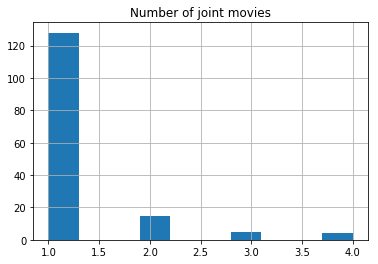

In [11]:
joint_movies_df = pd.DataFrame({
    'Actor name': list(joint_movies.keys()),
    'Number of joint movies': list(joint_movies.values())})
joint_movies_df

#joint_movies_df.columns = ['Actor Name', 'Number of joint movies']

joint_movies_df.hist(column='Number of joint movies')

In [10]:
joint_movies_df

,Actor name,Number of joint movies
0,Vin Diesel,4
1,Paul Walker,4
2,Michelle Rodríguez,1
3,Jordana Brewster,4
4,John Ortiz,2
5,Laz Alonso,1
6,Jack Conley,1
7,Shea Whigham,2
8,Tego Calderón,2
9,Don Omar,1
